# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'

fm.fontManager.addfont(arial_font_path)

plt.rcParams['font.family'] = 'Arial'

# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S21

## Panel A

In [3]:
import pandas as pd
## LOAD ROCKLIN DATA ##

rocklin_query_protein = pd.read_csv(path+'Fig3/FYN_Tsuboyama.txt',sep='\t',index_col=0)

rocklin_query_protein['del']=False
for index, row in rocklin_query_protein.iterrows():
    if len(row['name'].split('_'))>1:
        if row['name'].split('_')[1].startswith('del')==True:
            rocklin_query_protein.at[index,'del']=True
            rocklin_query_protein.at[index,'mutations']=row['name'].split('_')[1][3]+str(int(row['name'].split('_')[1][4:])-1)+'-'

## LOAD THERMOMUT DATA ##

thermomut = pd.read_csv(path+'Fig3/FYN_thermomut.txt',sep='\t', index_col=0)

In [4]:
### SCALE VALUES TO MATCH IDENTITY LINE ###

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from matplotlib.lines import Line2D  # For adding custom legend markers
import math

plt.rcParams['font.family'] = 'Arial'


coefs = pd.read_csv(path+'Fig6/FYN_suppressor_mochi_order2_sparse_regularized/task_4/weights/weights_Folding.txt', sep='\t')

coefs.rename(columns={'ci95_kcal/mol': 'ci95_kcal_mol'}, inplace=True)
for index, row in coefs.iterrows():
    if row.id_ref == 'WT':
        coefs.at[index, 'order'] = 0
    else:
        coefs.at[index, 'order'] = len(row.id.split('_'))

firstorderterms = coefs.loc[coefs['order'] == 1].copy()

rocklin_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
    rocklin_query_protein.loc[rocklin_query_protein['redundant_single']==False][['mutations', 'deltaG', 'deltaG_95CI']], 
    left_on='id', right_on='mutations'
)
rocklin_merge.set_index('id', inplace=True)
del rocklin_merge['mutations']

rocklins_wt_dg = -1 * rocklin_query_protein.loc[rocklin_query_protein['name'] == '1A0N.pdb'].iloc[0]['deltaG']
rocklins_wt_dg_SE = (-1 * rocklin_query_protein.loc[rocklin_query_protein['name'] == '1A0N.pdb'].iloc[0]['deltaG_95CI']) / 1.96
alberts_wt_dg = float(coefs.loc[coefs['id'] == 'WT'].iloc[0]['mean'])
for index, row in rocklin_merge.iterrows():
    variant_dg_SE = (-1 * row.deltaG_95CI) / 1.96
    variant_ddg_SE = math.sqrt((rocklins_wt_dg_SE**2) + (variant_dg_SE**2))
    rocklin_merge.at[index, 'rocklin_dGf'] = -1 * row.deltaG
    rocklin_merge.at[index, 'rocklin_ddGf'] = (-1 * row.deltaG) - rocklins_wt_dg
    rocklin_merge.at[index, 'rocklin_ddGf_SE'] = variant_ddg_SE
    rocklin_merge.at[index, 'rocklin_ddGf_CI95'] = variant_ddg_SE * 1.96
    rocklin_merge.at[index, 'albert_dGf'] = alberts_wt_dg + row['mean']
rocklin_avg = pd.DataFrame()
rocklin_merge=rocklin_merge.reset_index()
rocklin_avg["id"] = pd.Series(dtype="object") 
for index, row in rocklin_merge.value_counts('id').to_frame().iterrows():
    multiple_measurements = rocklin_merge.loc[rocklin_merge['id']==index]
    rocklin_avg.at[index,'id']=index
    rocklin_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
    rocklin_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
    rocklin_avg.at[index,'Nham']=multiple_measurements.iloc[0]['order']
    rocklin_avg.at[index,'prev_ddG']=multiple_measurements['rocklin_ddGf'].mean()
    rocklin_avg.at[index,'prev_SE']=multiple_measurements['rocklin_ddGf_SE'].mean()
rocklin_merge = rocklin_avg.copy()

thermomut_merge = firstorderterms[['id', 'mean', 'std', 'order']].merge(
    thermomut.loc[(thermomut['order'] == 1) & (thermomut['ΔΔG'].notna())][['ΔΔG', 'Mut1', 'order']], 
    left_on='id', right_on='Mut1'
).drop_duplicates().set_index('Mut1').sort_values('mean').copy()
thermomut_avg = pd.DataFrame()
thermomut_avg["id"] = pd.Series(dtype="object") 
for index, row in thermomut_merge.value_counts('id').to_frame().iterrows():
    multiple_measurements = thermomut_merge.loc[thermomut_merge['id']==index]
    thermomut_avg.at[index,'id']=index
    thermomut_avg.at[index,'mean']=multiple_measurements.iloc[0]['mean']
    thermomut_avg.at[index,'std']=multiple_measurements.iloc[0]['std']
    thermomut_avg.at[index,'order_x']=multiple_measurements.iloc[0]['order_x']
    thermomut_avg.at[index,'ΔΔG']=multiple_measurements['ΔΔG'].mean()
    thermomut_avg.at[index,'iv_std']=multiple_measurements['ΔΔG'].std()
thermomut_core = thermomut_avg[['ΔΔG','iv_std','mean','std','order_x']].copy()
thermomut_core = thermomut_core.rename(columns={'ΔΔG':'prev_ddG','iv_std':'prev_SE','order_x':'Nham'})
thermomut_core['Dataset']='ThermoMutDB'
#rocklin_merge = rocklin_merge.rename(columns={'rocklin_ddGf': 'prev_ddG', 'rocklin_ddGf_SE': 'prev_SE', 'order': 'Nham'})
rocklin_merge['Dataset'] = 'cDNA display proteolysis'
all_core_ddGf_validations = pd.concat(
    [thermomut_core[['prev_ddG', 'prev_SE', 'mean', 'std', 'Dataset', 'Nham']],
     rocklin_merge[['prev_ddG', 'prev_SE', 'mean', 'std', 'Dataset', 'Nham']]],
    axis=0
)

x = all_core_ddGf_validations[['mean']].to_numpy()
y = all_core_ddGf_validations[['prev_ddG']].to_numpy()
model = LinearRegression()
model.fit(x, y)
slope = model.coef_[0][0]
intercept = model.intercept_[0]

In [5]:
secondorderterms=coefs.loc[coefs['order']==2].copy()

secondorderterms['mutation1']='a'
secondorderterms['mutation2']='a'
for index,row in secondorderterms.iterrows():
    secondorderterms.at[index,'mutation1']=row.id.split('_')[0]
    secondorderterms.at[index,'mutation2']=row.id.split('_')[1]

secondorderterms['scaled_ddGs']=secondorderterms['mean']*slope
secondorderterms['scaled_ddG_std']=secondorderterms['std']*slope
secondorderterms.to_csv(path+'Fig6/Suppressor_2ndordermodel_secondorderterms_scaled_w_iv_values.txt',sep='\t')

single_mutations=[]
for index, row in secondorderterms.iterrows():
    if row.mutation1 not in single_mutations:
        single_mutations.append(row.mutation1)
for index, row in secondorderterms.iterrows():
    if row.mutation2 not in single_mutations:
        single_mutations.append(row.mutation2)    
single_mutations=sorted(single_mutations, key=lambda x: (int(x[1:-1]), x[-1]) )

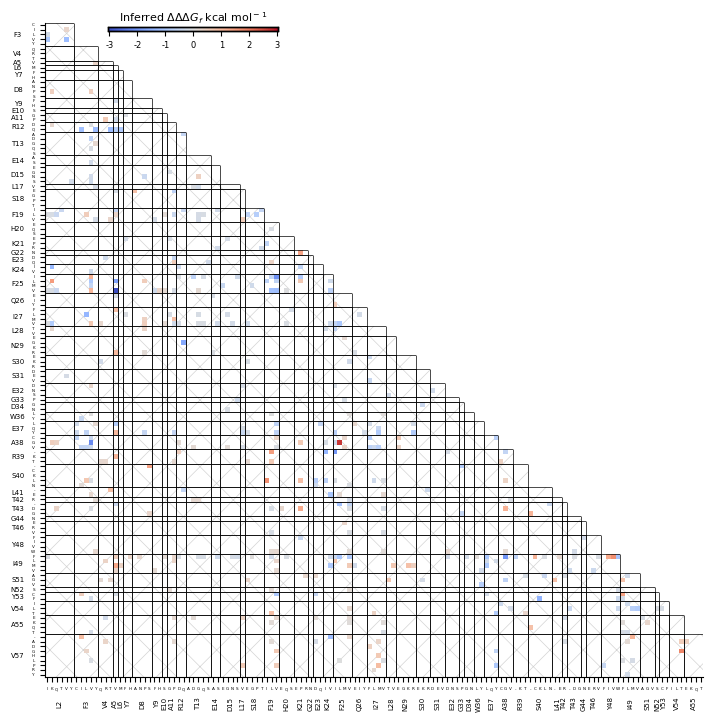

In [6]:
from matplotlib.patches import Rectangle
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
import matplotlib as mpl
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Sans'

pairwise_secondorderterms=pd.DataFrame(columns=single_mutations)

for index, row in secondorderterms.iterrows():
    pairwise_secondorderterms.at[row.mutation1,row.mutation2]=row['mean']

for index, row in secondorderterms.iterrows():
    pairwise_secondorderterms.at[row.mutation2,row.mutation1]=row['mean']

pairwise_secondorderterms=pairwise_secondorderterms*slope
pairwise_secondorderterms=pairwise_secondorderterms.fillna(np.nan)
pairwise_secondorderterms=pairwise_secondorderterms.reindex(single_mutations)

#plt.figure(figsize=(10,8))
fig, ax=plt.subplots(figsize=(8.5,8.5))


mask = np.zeros_like(pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]], dtype=bool)

rowiterator=0
columniterator=0
for index, row in pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]].iterrows():
    for column in pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]].columns:
        if int(row.name[1:-1]) <= int(column[1:-1]):
            mask[rowiterator, columniterator]=True
            columniterator+=1
        else:
            mask[rowiterator, columniterator]=False
            columniterator+=1
    columniterator=0
    rowiterator+=1
    
mask



            
cbar_ax=fig.add_axes([0.2,0.87,0.2,0.005])

mpl.rcParams['hatch.linewidth'] = 0.5
ax.patch.set(hatch='x', edgecolor='#D3D3D3')
ax.patch.set_linewidth(0)
ax.set_facecolor('white')
couplings_boundary=abs(pairwise_secondorderterms).fillna(0).to_numpy().max()
hmap=sns.heatmap(pairwise_secondorderterms.iloc[list(Counter([i[:-1] for i in single_mutations]).values())[0]:,:-1*list(Counter([i[:-1] for i in single_mutations]).values())[-1]], cmap='coolwarm', center=0, xticklabels=True,yticklabels=True, mask=mask,vmin=-1*couplings_boundary, vmax=couplings_boundary,
              cbar_kws={"orientation": "horizontal", "pad": 0.02, 'ticks':list(np.arange(-2,3,1))}, ax=ax, cbar_ax=cbar_ax, fmt= '', annot_kws={'size':4})


#ax.figure.axes[-1].set_ylabel('ddG', rotation=270)
cbar_ax.set_xlabel(r'Inferred ${ΔΔΔG_{f}}$ kcal mol$^-$$^1$', rotation=0, fontsize=8)
cbar_ax.xaxis.set_label_position('top')
cbar_ax.set_xticks(np.arange(-3,4,1), [str(round(i,1)) for i in np.arange(-3,4,1)], fontsize=6)
for spine in cbar_ax.spines.values():
    spine.set(visible=True,lw=1,edgecolor='black')

    
labels_x = [item.get_text() for item in ax.get_xticklabels()]
for label_nr, label in enumerate(labels_x):
    labels_x[label_nr]=label[-1]
ax.set_xticklabels(labels_x, rotation=0,fontsize=3)
labels_y = [item.get_text() for item in ax.get_yticklabels()]
for label_nr, label in enumerate(labels_y):
    labels_y[label_nr]=label[-1]
ax.set_yticklabels(labels_y, rotation=0,fontsize=3)


start_row=0
start_col=0

codes= [Path.MOVETO, Path.LINETO]
for rows in enumerate(list(Counter([i[:-1] for i in single_mutations]).values())[1:]):
    for cols in enumerate(list(Counter([i[:-1] for i in single_mutations]).values())[:]):
        if rows[0]<cols[0]:
            rect = Rectangle((start_col, start_row), cols[1], rows[1], linewidth=0,facecolor='white')
            ax.add_patch(rect)
            if cols[0]-rows[0]==1:
                rx, ry = rect.get_xy()
                cx = rx + rect.get_width()
                cy = ry + rect.get_height()
                vertices=[(rx,ry), (rx, cy)]
                pth= Path(vertices, codes)
                line_patch = PathPatch(pth, lw=0.5, color='k')
                ax.add_patch(line_patch)
        else:
            rect = Rectangle((start_col, start_row), cols[1], rows[1], linewidth=0.5, edgecolor='black',facecolor='none')
            ax.add_patch(rect)
            
            rx, ry = rect.get_xy()
            cx = rx + rect.get_width()/2
            cy = ry + rect.get_height()/2
            if start_col == 0:
                ax.annotate(list(Counter([i[:-1] for i in single_mutations]).keys())[1:][rows[0]], (cx-8.5,cy), ha= 'center', va='center',fontsize=5, annotation_clip=False)
            if start_row == (sum(list(Counter([i[:-1] for i in single_mutations]).values())[1:])-rows[1]):
                ax.annotate(list(Counter([i[:-1] for i in single_mutations]).keys())[:][cols[0]], (cx,cy+10), ha= 'center', va='center',fontsize=5, annotation_clip=False, rotation=90)
        
            
        start_col=start_col+cols[1]
        
    start_col=0
    start_row=start_row+rows[1]

ax.spines[['left','bottom']].set_visible(True)
ax.spines[['top','right']].set_visible(False)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Suppressor_2ndordersprsreg_2ndorderterms.png', dpi=300, bbox_inches = "tight")

## Panel B

In [7]:
secondorderterms_2ndorder = pd.read_csv(path+'FigS5/FYN_mochiorder2_secondorderterms_scaled_w_iv_values.txt',
                       sep='\t', index_col=0)

secondorderterms_2ndorder_sprsreg = pd.read_csv(path+'FigS5/FYN_mochiorder2_sparse_regularized_secondorderterms_scaled_w_iv_values.txt',
                       sep='\t', index_col=0)

secondorderterms = secondorderterms.rename(columns={'scaled_ddGs':'suppressor_ddGs', 'scaled_ddG_std':'suppressor_ddGs_std'})

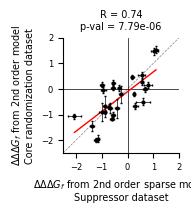

In [8]:
weights_merger = secondorderterms[['suppressor_ddGs','suppressor_ddGs_std','id_ref']].merge(secondorderterms_2ndorder[['scaled_ddGs','scaled_ddG_std','id_ref']], left_on='id_ref', right_on='id_ref')

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

weights_merger=weights_merger.sort_values('suppressor_ddGs')

x = weights_merger[['suppressor_ddGs']].to_numpy()
y = weights_merger[['scaled_ddGs']].to_numpy()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),y_pred.ravel())

fig, ax=plt.subplots(figsize=(1.5,1.5))
ax.axline((0, 0), slope=1, linestyle="dashed", color='gray', lw=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
plt.plot(x, y_pred, color='red', linewidth=1, linestyle='-')
ax.errorbar(weights_merger[['suppressor_ddGs']].to_numpy().ravel(),weights_merger[['scaled_ddGs']].to_numpy().ravel(),weights_merger[['scaled_ddG_std']].to_numpy().ravel(),weights_merger[['suppressor_ddGs_std']].to_numpy().ravel(), color='k',linewidth=0,
           markersize=2,marker='o', capsize=0.5, elinewidth=0.5)
ax.set_xlabel(r'${ΔΔΔG_{f}}$ from 2nd order sparse model'+'\nSuppressor dataset', fontsize=7)
ax.set_ylabel(r'${ΔΔΔG_{f}}$ from 2nd order model'+'\nCore randomization dataset', fontsize=7)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=6)
ax.set_xticks(np.arange(-2,3,1))
ax.set_yticks(np.arange(-2,3,1))
ax.set_xlim(-2.5,2)
ax.set_ylim(-2.5,2)
#ax.set_xticklabels(np.arange(0,4,1))
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Suppressor_vs_2ndordercore_model_2ndorderterms.svg', dpi=300, transparent=True)


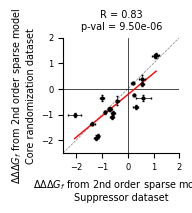

In [9]:
weights_merger = secondorderterms[['suppressor_ddGs','suppressor_ddGs_std','id_ref']].merge(secondorderterms_2ndorder_sprsreg[['scaled_ddGs','scaled_ddG_std','id_ref']], left_on='id_ref', right_on='id_ref')

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score

weights_merger=weights_merger.sort_values('suppressor_ddGs')

x = weights_merger[['suppressor_ddGs']].to_numpy()
y = weights_merger[['scaled_ddGs']].to_numpy()

model = LinearRegression()
model.fit(x, y)

y_pred = model.predict(x)
r2 = r2_score(y,y_pred)
r,p = pearsonr(y.ravel(),y_pred.ravel())

fig, ax=plt.subplots(figsize=(1.5,1.5))
ax.axline((0, 0), slope=1, linestyle="dashed", color='gray', lw=0.5)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
plt.plot(x, y_pred, color='red', linewidth=1, linestyle='-')
ax.errorbar(weights_merger[['suppressor_ddGs']].to_numpy().ravel(),weights_merger[['scaled_ddGs']].to_numpy().ravel(),weights_merger[['scaled_ddG_std']].to_numpy().ravel(),weights_merger[['suppressor_ddGs_std']].to_numpy().ravel(), color='k',linewidth=0,
           markersize=2,marker='o', capsize=0.5, elinewidth=0.5)
ax.set_xlabel(r'${ΔΔΔG_{f}}$ from 2nd order sparse model'+'\nSuppressor dataset', fontsize=7)
ax.set_ylabel(r'${ΔΔΔG_{f}}$ from 2nd order sparse model'+'\nCore randomization dataset', fontsize=7)
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(labelsize=6)
ax.set_xticks(np.arange(-2,3,1))
ax.set_yticks(np.arange(-2,3,1))
ax.set_xlim(-2.5,2)
ax.set_ylim(-2.5,2)
#ax.set_xticklabels(np.arange(0,4,1))
plt.title('R = '+str(round(r,2))+ '\np-val = '+'{:0.2e}'.format(p), fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Suppressor_vs_2ndordersprsregcore_model_2ndorderterms.svg', dpi=300, transparent=True)


## Panel C

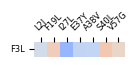

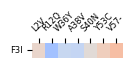

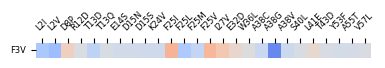

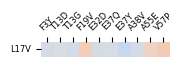

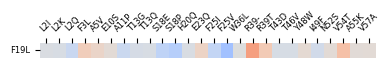

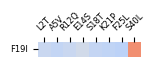

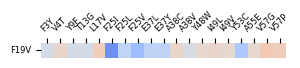

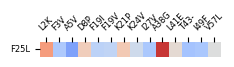

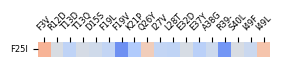

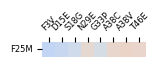

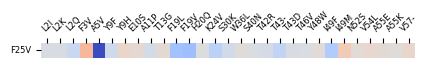

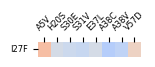

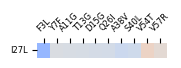

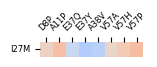

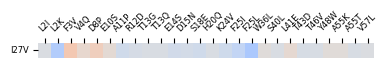

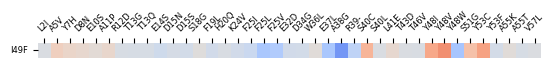

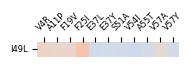

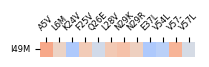

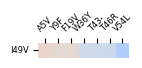

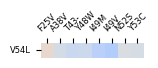

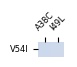

In [10]:
DTS=['F','L','I','M','V']
fyn_core_pos = [2,16,18,24,26,48,53]
fyn_wt_core = 'FLFFIIV'

fyn_core_singles=[]
for wt_res, pos in zip(fyn_wt_core,fyn_core_pos):
    for mut_to in DTS:
        if wt_res != mut_to:
            fyn_core_singles.append(wt_res+str(pos+1)+mut_to)
plt.rcParams['figure.max_open_warning'] = 100
for single_core_mutation in fyn_core_singles:
    try:
        width=len(pairwise_secondorderterms.loc[pairwise_secondorderterms[single_core_mutation].notnull()][[single_core_mutation]].T.columns)
        plt.figure(figsize=(width/6,0.2))
        ax=sns.heatmap(pairwise_secondorderterms.loc[pairwise_secondorderterms[single_core_mutation].notnull()][[single_core_mutation]].T, cmap='coolwarm', center=0, xticklabels=True,yticklabels=True,cbar=False,cbar_kws={"orientation": "horizontal", "pad": 0.02, 'location':'bottom'},
                      vmax=abs(pairwise_secondorderterms).fillna(0).to_numpy().max(), vmin=-1*abs(pairwise_secondorderterms).fillna(0).to_numpy().max())
        ax.xaxis.set_label_position('top')
        plt.yticks(fontsize=6, rotation=0)
        plt.tick_params(axis='both', which='both', labelbottom=False, bottom=False, top=True, labeltop=True)
        plt.xticks(rotation=45,fontsize=6)
        plt.rcParams['svg.fonttype'] = 'none'
#        plt.savefig('Suppressor_2ndordersprsreg_2ndorderterms'+pairwise_secondorderterms.loc[pairwise_secondorderterms[single_core_mutation].notnull()][[single_core_mutation]].T.index[0]+'.svg', dpi=300, bbox_inches = "tight")
    except:
        continue